# Predicting T2DM 30-Day Readmission

Group member: Yifan Bai, Min Xu, Olimpia Borgohain, Kunjingyi Chen.

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/admission_1209_stay_type.csv')
data.head()

,Unnamed: 0,hadm_id,subject_id,race,insurance,admission_type,los_hours,admission_location,discharge_location,gender,...,direct_emer_stay,urgent_stay,observation_admit_stay,direct_observation_stay,elective_stay,eu_observation_stay,ew_emer_stay,surgical_same_day_stay,ambulatory_observation_stay,readmit_30d
0,0,25241567,17876596,WHITE,Private,URGENT,29,PHYSICIAN REFERRAL,HOME,F,...,0,0,0,0,0,0,0,0,0,False
1,1,20472406,10677944,WHITE,Private,URGENT,666,INTERNAL TRANSFER TO OR FROM PSYCH,ASSISTED LIVING,M,...,0,0,0,0,0,0,0,0,0,False
2,2,28583591,15655633,WHITE,Medicare,URGENT,287,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,F,...,0,0,0,0,0,0,0,0,0,False
3,3,28201230,10813632,WHITE,Private,URGENT,310,TRANSFER FROM HOSPITAL,HOME,M,...,0,0,0,0,0,0,0,0,0,False
4,4,26739664,17321813,BLACK/AFRICAN AMERICAN,Medicare,URGENT,352,TRANSFER FROM HOSPITAL,REHAB,M,...,0,0,0,0,0,0,0,0,0,False


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20082 entries, 0 to 20081
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   20082 non-null  int64  
 1   hadm_id                      20082 non-null  int64  
 2   subject_id                   20082 non-null  int64  
 3   race                         20082 non-null  object 
 4   insurance                    19971 non-null  object 
 5   admission_type               20082 non-null  object 
 6   los_hours                    20082 non-null  int64  
 7   admission_location           20082 non-null  object 
 8   discharge_location           20082 non-null  object 
 9   gender                       20082 non-null  object 
 10  age                          20082 non-null  int64  
 11  diagnoses_count              20082 non-null  int64  
 12  labtest_count                20082 non-null  int64  
 13  medication_count

## A. Data Preprocessing

### 1.Drop useless columns

In [3]:
data = data.drop(['Unnamed: 0','subject_id','hadm_id'], axis=1)

### 2.Feature creation

#### (1) Creating Complications feature

In [4]:
import pandas as pd

# Comprehensive ICD-to-Cluster mapping with "Complication" removed
icd_to_cluster = {
    # No Complications
    "25000": "No",
    "E119": "No",

    # Hyperglycemic Complications
    "25020": "Hyperglycemic",
    "25022": "Hyperglycemic",
    "E1100": "Hyperglycemic",
    "E1101": "Hyperglycemic",
    "E1165": "Hyperglycemic",

    # Ketoacidosis
    "25010": "Ketoacidosis",
    "25012": "Ketoacidosis",
    "E1110": "Ketoacidosis",
    "E1111": "Ketoacidosis",

    # Renal Complications
    "25040": "Renal",
    "25042": "Renal",
    "E1121": "Renal",
    "E1122": "Renal",
    "E1129": "Renal",

    # Ophthalmic Complications
    "25050": "Ophthalmic",
    "25052": "Ophthalmic",
    "E11311": "Ophthalmic",
    "E11319": "Ophthalmic",
    "E113211": "Ophthalmic",
    "E113212": "Ophthalmic",
    "E113213": "Ophthalmic",
    "E113219": "Ophthalmic",
    "E113291": "Ophthalmic",
    "E113292": "Ophthalmic",
    "E113293": "Ophthalmic",
    "E113299": "Ophthalmic",
    "E113311": "Ophthalmic",
    "E113319": "Ophthalmic",
    "E113391": "Ophthalmic",
    "E113399": "Ophthalmic",
    "E113411": "Ophthalmic",
    "E113419": "Ophthalmic",
    "E113491": "Ophthalmic",
    "E113499": "Ophthalmic",
    "E113511": "Ophthalmic",
    "E113519": "Ophthalmic",
    "E113521": "Ophthalmic",
    "E113529": "Ophthalmic",
    "E113531": "Ophthalmic",
    "E113539": "Ophthalmic",
    "E113541": "Ophthalmic",
    "E113549": "Ophthalmic",
    "E113591": "Ophthalmic",
    "E113599": "Ophthalmic",
    "E1136": "Ophthalmic",
    "E1137X1": "Ophthalmic",
    "E1137X2": "Ophthalmic",
    "E1137X3": "Ophthalmic",
    "E1137X9": "Ophthalmic",
    "E1139": "Ophthalmic",

    # Neurological Complications
    "25060": "Neurological",
    "25062": "Neurological",
    "E1140": "Neurological",
    "E1141": "Neurological",
    "E1142": "Neurological",
    "E1143": "Neurological",
    "E1144": "Neurological",
    "E1149": "Neurological",

    # Circulatory Complications
    "25070": "Circulatory",
    "25072": "Circulatory",
    "E1151": "Circulatory",
    "E1152": "Circulatory",
    "E1159": "Circulatory",

    # Skin and Foot Complications
    "E11620": "Skin and Foot",
    "E11621": "Skin and Foot",
    "E11622": "Skin and Foot",
    "E11628": "Skin and Foot",

    # Oral Complications
    "E11630": "Oral",
    "E11638": "Oral",

    # Hypoglycemic Complications
    "E11641": "Hypoglycemic",
    "E11649": "Hypoglycemic",

    # Other Metabolic Complications
    "25080": "Other Metabolic",
    "25082": "Other Metabolic",
    "25090": "Other Metabolic",
    "25092": "Other Metabolic",

    # Unspecified or Other Complications
    "E1169": "Unspecified or Other",
    "E118": "Unspecified or Other",
}

# Function to determine complication type for a single row
def assign_complication(row):
    for diagnosis in [row["diagnosis_1"], row["diagnosis_2"], row["diagnosis_3"]]:
        if diagnosis in icd_to_cluster:
            return icd_to_cluster[diagnosis]
    return "Unknown"

# Apply function to each row to determine complications
data["Complication"] = data.apply(assign_complication, axis=1)

# Display resulting DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20082 entries, 0 to 20081
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   race                         20082 non-null  object 
 1   insurance                    19971 non-null  object 
 2   admission_type               20082 non-null  object 
 3   los_hours                    20082 non-null  int64  
 4   admission_location           20082 non-null  object 
 5   discharge_location           20082 non-null  object 
 6   gender                       20082 non-null  object 
 7   age                          20082 non-null  int64  
 8   diagnoses_count              20082 non-null  int64  
 9   labtest_count                20082 non-null  int64  
 10  medication_count             20082 non-null  int64  
 11  procedure_count              20082 non-null  int64  
 12  max_a1c                      3692 non-null   float64
 13  max_glucose     

In [5]:
data['Complication'].unique()

array(['No', 'Unknown', 'Neurological', 'Renal', 'Unspecified or Other',
       'Other Metabolic', 'Ketoacidosis', 'Hyperglycemic', 'Ophthalmic',
       'Circulatory', 'Skin and Foot', 'Hypoglycemic'], dtype=object)

#### (2) Creating other features

We created los_hours(length of stay), diagnoses_count, labtest_count, medication_count, procedure_count, total_num_of_stay, direct_emer_stay, urgent_stay, observation_admit_stay, direct_observation_stay, elective_stay, eu_observation_stay, ew_emer_stay,surgical_same_day_stay and ambulatory_observation_stay using SQL.

### 3.Standardizing Categorical Variables


#### (1) Diagnosis mapping

In [6]:
# Define ICD-9 code ranges for each category
def categorize_icd9(code):
    try:
        code = int(str(code)[:3])
    except ValueError:
        return "Others"

    # Map ranges to categories
    if 390 <= code <= 459 or code == 785:
        return "Circulatory"
    elif 460 <= code <= 519 or code == 786:
        return "Respiratory"
    elif 520 <= code <= 579 or code == 787:
        return "Digestive"
    elif 250 <= code <= 250:
        return "Diabetes"
    elif 800 <= code <= 999:
        return "Injury"
    elif 710 <= code <= 739:
        return "Musculoskeletal"
    elif 580 <= code <= 629 or code == 788:
        return "Genitourinary"
    elif 140 <= code <= 239:
        return "Neoplasms"
    else:
        return "Others"

# Apply the function to each diagnosis column
for col in ['diagnosis_1', 'diagnosis_2', 'diagnosis_3','diagnosis_4','diagnosis_5']:
    data[col] = data[col].apply(categorize_icd9)

# Display the transformed diagnosis columns to verify
data[['diagnosis_1', 'diagnosis_2', 'diagnosis_3','diagnosis_4','diagnosis_5']].head()


,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5
0,Neoplasms,Circulatory,Diabetes,Others,Others
1,Others,Others,Others,Others,Diabetes
2,Circulatory,Genitourinary,Diabetes,Digestive,Others
3,Circulatory,Others,Circulatory,Diabetes,Others
4,Circulatory,Respiratory,Others,Diabetes,Others


#### (2) Race Mapping

In [7]:
data['race'].unique()

array(['WHITE', 'BLACK/AFRICAN AMERICAN', 'UNKNOWN', 'ASIAN - CHINESE',
       'BLACK/CAPE VERDEAN', 'BLACK/AFRICAN', 'OTHER',
       'HISPANIC/LATINO - PUERTO RICAN', 'UNABLE TO OBTAIN',
       'WHITE - RUSSIAN', 'ASIAN', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'WHITE - OTHER EUROPEAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - MEXICAN',
       'PATIENT DECLINED TO ANSWER',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'ASIAN - ASIAN INDIAN', 'HISPANIC/LATINO - SALVADORAN',
       'WHITE - EASTERN EUROPEAN', 'PORTUGUESE', 'BLACK/CARIBBEAN ISLAND',
       'WHITE - BRAZILIAN', 'ASIAN - SOUTH EAST ASIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN',
       'HISPANIC/LATINO - GUATEMALAN', 'SOUTH AMERICAN', 'ASIAN - KOREAN',
       'MULTIPLE RACE/ETHNICITY', 'HISPANIC/LATINO - CUBAN'], dtype=object)

In [8]:
# Define a mapping function for the 'race' column with more specific conditions
def map_race_category(race):
    race = race.lower()

    if "white" in race:
        return "Caucasian"
    elif "asian" in race:
        return "Asian"
    elif "black" in race or "african" in race:
        return "African American"
    elif "hispanic" in race or "latino" in race:
        return "Hispanic"
    elif "american indian" in race or "alaska native" in race:
        return "Other"
    elif "hawaiian" in race or "pacific islander" in race:
        return "Other"
    elif "multiple race" in race or "unable to obtain" in race or "unknown" in race or "declined" in race:
        return "Other"
    else:
        return "Other"

# Apply the mapping function to the 'race' column
data['race'] = data['race'].apply(map_race_category)
data['race'].value_counts()


,count
race,
Caucasian,12136
African American,3939
Other,1886
Hispanic,1424
Asian,697


### 4.Detecting outliers

In [9]:
# Detect outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return lower_bound, upper_bound, outliers

numerical_cols = data.select_dtypes(include=np.number).columns

# Initialize a list to store the outlier information
outlier_summary = []

for col in numerical_cols:
    lower_bound, upper_bound, outliers = detect_outliers_iqr(data[col])
    if not outliers.empty:
        outlier_range = (outliers.min(), outliers.max())
    else:
        outlier_range = (None, None)
    outlier_count = len(outliers)
    outlier_summary.append({
        'Column': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Range': outlier_range,
        'Outlier Count': outlier_count
    })

# Convert summary to a DF
outlier_summary_df = pd.DataFrame(outlier_summary)
outlier_summary_df


,Column,Lower Bound,Upper Bound,Outlier Range,Outlier Count
0,los_hours,-87.0,321.0,"(322, 5369)",1255
1,age,32.5,100.5,"(19, 32)",178
2,diagnoses_count,-4.5,31.5,"(32, 39)",475
3,labtest_count,-179.0,461.0,"(462, 4439)",1150
4,medication_count,-0.5,59.5,"(60, 126)",1065
5,procedure_count,-2.0,6.0,"(7, 40)",1157
6,max_a1c,NaN,NaN,"(None, None)",0
7,max_glucose,NaN,NaN,"(None, None)",0
8,total_num_of_stay,-1.5,2.5,"(3, 13)",1884
9,direct_emer_stay,0.0,0.0,"(1, 5)",1158


### 5.Handling missing values

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# Replace "?" with NaN for standard missing value encoding
data.replace("?", np.nan, inplace=True)

# Drop columns with 50% or more missing values (except 'max_a1c' and 'payer_code')
threshold = 0.5 * len(data)
cols_to_drop = [col for col in data.columns if data[col].isna().sum() > threshold and col not in ['max_a1c', 'payer_code']]
data.drop(columns=cols_to_drop, inplace=True)

# Encode categorical columns for imputation
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

# Convert encoded categorical columns back to their original type
for col in categorical_cols:
    le = label_encoders[col]
    data_imputed[col] = le.inverse_transform(data_imputed[col].round().astype(int))

data_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20082 entries, 0 to 20081
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   race                         20082 non-null  object 
 1   insurance                    20082 non-null  object 
 2   admission_type               20082 non-null  object 
 3   los_hours                    20082 non-null  float64
 4   admission_location           20082 non-null  object 
 5   discharge_location           20082 non-null  object 
 6   gender                       20082 non-null  object 
 7   age                          20082 non-null  float64
 8   diagnoses_count              20082 non-null  float64
 9   labtest_count                20082 non-null  float64
 10  medication_count             20082 non-null  float64
 11  procedure_count              20082 non-null  float64
 12  max_a1c                      20082 non-null  float64
 13  max_glucose     

### 6.Convert columns to their respective data types

In [11]:
data_imputed.head(10)

,race,insurance,admission_type,los_hours,admission_location,discharge_location,gender,age,diagnoses_count,labtest_count,...,urgent_stay,observation_admit_stay,direct_observation_stay,elective_stay,eu_observation_stay,ew_emer_stay,surgical_same_day_stay,ambulatory_observation_stay,readmit_30d,Complication
0,Caucasian,Private,URGENT,29.0,PHYSICIAN REFERRAL,HOME,F,64.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
1,Caucasian,Private,URGENT,666.0,INTERNAL TRANSFER TO OR FROM PSYCH,ASSISTED LIVING,M,77.0,21.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
2,Caucasian,Medicare,URGENT,287.0,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,F,84.0,13.0,266.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
3,Caucasian,Private,URGENT,310.0,TRANSFER FROM HOSPITAL,HOME,M,61.0,6.0,314.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
4,African American,Medicare,URGENT,352.0,TRANSFER FROM HOSPITAL,REHAB,M,66.0,16.0,364.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
5,Caucasian,Private,URGENT,184.0,TRANSFER FROM HOSPITAL,HOME,F,65.0,11.0,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
6,Other,Private,URGENT,244.0,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,M,48.0,13.0,208.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unknown
7,Caucasian,Medicare,URGENT,72.0,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,F,91.0,7.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
8,African American,Private,URGENT,69.0,PHYSICIAN REFERRAL,HOME,M,64.0,7.0,63.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Neurological
9,Caucasian,Medicare,URGENT,160.0,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,M,72.0,7.0,115.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Unknown


In [12]:
# Define columns_to_int
columns_to_int = [
    'los_hours', 'age', 'diagnoses_count', 'labtest_count',
    'medication_count', 'procedure_count', 'metformin', 'repaglinide',
    'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
    'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'diabetic_med', 'readmit_30d'
]

# Convert the specified columns to integer
for column in columns_to_int:
    data_imputed[column] = data_imputed[column].astype(int)

print(data_imputed.dtypes)

race                            object
insurance                       object
admission_type                  object
los_hours                        int64
admission_location              object
discharge_location              object
gender                          object
age                              int64
diagnoses_count                  int64
labtest_count                    int64
medication_count                 int64
procedure_count                  int64
max_a1c                        float64
max_glucose                    float64
metformin                        int64
repaglinide                      int64
nateglinide                      int64
chlorpropamide                   int64
glimepiride                      int64
acetohexamide                    int64
glipizide                        int64
glyburide                        int64
tolbutamide                      int64
pioglitazone                     int64
rosiglitazone                    int64
acarbose                 

In [13]:
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20082 entries, 0 to 20081
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   race                         20082 non-null  object 
 1   insurance                    20082 non-null  object 
 2   admission_type               20082 non-null  object 
 3   los_hours                    20082 non-null  int64  
 4   admission_location           20082 non-null  object 
 5   discharge_location           20082 non-null  object 
 6   gender                       20082 non-null  object 
 7   age                          20082 non-null  int64  
 8   diagnoses_count              20082 non-null  int64  
 9   labtest_count                20082 non-null  int64  
 10  medication_count             20082 non-null  int64  
 11  procedure_count              20082 non-null  int64  
 12  max_a1c                      20082 non-null  float64
 13  max_glucose     

In [14]:
data_imputed.head()

,race,insurance,admission_type,los_hours,admission_location,discharge_location,gender,age,diagnoses_count,labtest_count,...,urgent_stay,observation_admit_stay,direct_observation_stay,elective_stay,eu_observation_stay,ew_emer_stay,surgical_same_day_stay,ambulatory_observation_stay,readmit_30d,Complication
0,Caucasian,Private,URGENT,29,PHYSICIAN REFERRAL,HOME,F,64,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,No
1,Caucasian,Private,URGENT,666,INTERNAL TRANSFER TO OR FROM PSYCH,ASSISTED LIVING,M,77,21,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Unknown
2,Caucasian,Medicare,URGENT,287,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,F,84,13,266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,No
3,Caucasian,Private,URGENT,310,TRANSFER FROM HOSPITAL,HOME,M,61,6,314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Unknown
4,African American,Medicare,URGENT,352,TRANSFER FROM HOSPITAL,REHAB,M,66,16,364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Unknown


In [15]:
data_imputed.describe()

,los_hours,age,diagnoses_count,labtest_count,medication_count,procedure_count,max_a1c,max_glucose,metformin,repaglinide,...,direct_emer_stay,urgent_stay,observation_admit_stay,direct_observation_stay,elective_stay,eu_observation_stay,ew_emer_stay,surgical_same_day_stay,ambulatory_observation_stay,readmit_30d
count,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,...,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000,20082.000000
mean,139.909073,65.983169,14.097948,174.395678,31.336819,2.683149,7.789416,235.797879,0.208794,0.003685,...,0.071258,0.063838,0.195947,0.001693,0.036998,0.001096,0.325117,0.062195,0.000050,0.150583
std,137.433256,12.629719,6.911177,203.222869,13.991247,2.164962,1.501042,184.728555,0.406457,0.060593,...,0.317558,0.278199,0.638394,0.041113,0.249247,0.034554,0.842107,0.261893,0.007057,0.357650
min,24.000000,19.000000,2.000000,1.000000,1.000000,1.000000,4.000000,46.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.000000,58.000000,9.000000,61.000000,22.000000,1.000000,6.740000,146.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,104.000000,66.000000,13.000000,116.000000,28.000000,2.000000,7.460000,190.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,168.000000,75.000000,18.000000,221.000000,37.000000,3.000000,8.500000,255.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5369.000000,100.000000,39.000000,4439.000000,126.000000,40.000000,19.400000,5400.000000,1.000000,1.000000,...,5.000000,5.000000,10.000000,1.000000,10.000000,2.000000,11.000000,3.000000,1.000000,1.000000


### 7.Deal with class imbalance: SMOTEENN

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Prepare the data
X = data_imputed.drop('readmit_30d', axis=1)
y = data_imputed['readmit_30d']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling categorical variables
categorical_columns = ['race', 'insurance', 'admission_type', 'admission_location', 'discharge_location', 'gender', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3','diagnosis_4','diagnosis_5','Complication']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)

# Ensure X_test_encoded has the same columns as X_train_encoded
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Check the class distribution
print("Original class distribution:")
print(y_train.value_counts(normalize=True))
print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original class distribution:
readmit_30d
0    0.84986
1    0.15014
Name: proportion, dtype: float64

Resampled class distribution:
readmit_30d
1    0.675787
0    0.324213
Name: proportion, dtype: float64


## B. Initial Models

### 1.Simple MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
# Create an MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
					max_iter=1000, random_state=42)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Train the model on the training data
mlp.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = mlp.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.58
Precision: 0.17
Recall: 0.48
ROC AUC: 0.54


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
from sklearn.metrics import classification_report

classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1786
           1       0.17      0.48      0.25       308

    accuracy                           0.58      2094
   macro avg       0.52      0.54      0.48      2094
weighted avg       0.77      0.58      0.64      2094



In [ ]:
y_pred_proba  =mlp.predict_proba(X_test_scaled)[:, 1]

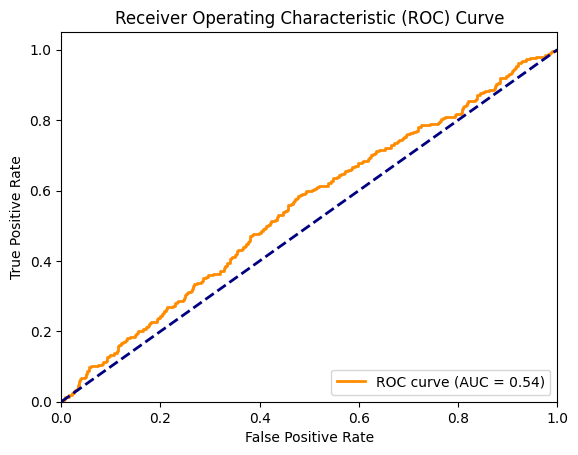

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 2.MLP(According to <Predicting 30-Day Hospital Readmission for Diabetes Patients using Multilayer Perceptron>)

Next, we will try the same MLP model which was applied to Health Facts National Database on Predicting 30-Day Hospital Readmission for Diabetes Patients.

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [ ]:
# Define the MLP model
def create_model(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim, kernel_initializer='uniform'),
        PReLU(),
        Dropout(0.15),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy', AUC()])
    return model


In [ ]:
# Train and evaluate the model multiple times
n_runs = 5
results = []

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}")

    model = create_model(X_train_resampled.shape[1])

    history = model.fit(
        X_train_resampled, y_train_resampled,
        batch_size=500,
        epochs=600,
        validation_split=0.2,
        verbose=0
    )

    y_pred = model.predict(X_test_scaled).ravel()
    y_pred_class = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred)

    results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc
    })

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    print()


Run 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6342
Precision: 0.1991
Recall: 0.4730
AUC: 0.5877

Run 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6156
Precision: 0.1928
Recall: 0.4873
AUC: 0.5879

Run 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6302
Precision: 0.1915
Recall: 0.4520
AUC: 0.5830

Run 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6176
Precision: 0.1962
Recall: 0.4972
AUC: 0.5923

Run 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.6357
Precision: 0.1930
Recall: 0.4465
AUC: 0.5783



In [ ]:
# Calculate average results
avg_results = {metric: np.mean([run[metric] for run in results]) for metric in results[0].keys()}

print("Average Results:")
for metric, value in avg_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Average Results:
Accuracy: 0.6267
Precision: 0.1945
Recall: 0.4712
Auc: 0.5858


The result of the MLP model we referenced were not satisfactory, so we will explore other machine learning model.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 3.Logistic Regression

In [ ]:
# Train
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = log_reg_model.predict(X_test_scaled)

# Evaluation
log_accuracy = accuracy_score(y_test, y_pred_class)
log_precision = precision_score(y_test, y_pred_class)
log_recall = recall_score(y_test, y_pred_class)
log_auc = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression Results:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"AUC: {log_auc:.4f}")

Logistic Regression Results:
Accuracy: 0.2998
Precision: 0.1631
Recall: 0.8842
AUC: 0.6163


### 4.Random Forest

In [ ]:
# Train
rf_model = RandomForestClassifier(random_state=42, n_estimators=500, class_weight={0:1,1:0.5}, max_depth = 3, min_samples_split= 50)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_rf = rf_model.predict(X_test_scaled)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_class_rf)
rf_precision = precision_score(y_test, y_pred_class_rf)
rf_recall = recall_score(y_test, y_pred_class_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"AUC: {rf_auc:.4f}")


Random Forest Results:
Accuracy: 0.6239
Precision: 0.2024
Recall: 0.5094
AUC: 0.6058


### 5.XGBoost

In [ ]:
# Train
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',learning_rate=0.01)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
xgb_accuracy = accuracy_score(y_test, y_pred_class_xgb)
xgb_precision = precision_score(y_test, y_pred_class_xgb)
xgb_recall = recall_score(y_test, y_pred_class_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC: {xgb_auc:.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:23:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.4120
Precision: 0.1781
Recall: 0.8037
AUC: 0.6177


### 6.LihtGBM

In [ ]:
# Train
lgbm_model = LGBMClassifier(random_state=42, n_estimators=100)
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_lgbm = lgbm_model.predict(X_test_scaled)

# Evaluation
lgbm_accuracy = accuracy_score(y_test, y_pred_class_lgbm)
lgbm_precision = precision_score(y_test, y_pred_class_lgbm)
lgbm_recall = recall_score(y_test, y_pred_class_lgbm)
lgbm_auc = roc_auc_score(y_test, y_pred_proba_lgbm)

print("LightGBM Results:")
print(f"Accuracy: {lgbm_accuracy:.4f}")
print(f"Precision: {lgbm_precision:.4f}")
print(f"Recall: {lgbm_recall:.4f}")
print(f"AUC: {lgbm_auc:.4f}")

[LightGBM] [Info] Number of positive: 11517, number of negative: 5769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6116
[LightGBM] [Info] Number of data points in the train set: 17286, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666262 -> initscore=0.691325
[LightGBM] [Info] Start training from score 0.691325
LightGBM Results:
Accuracy: 0.7407
Precision: 0.2459
Recall: 0.3495
AUC: 0.6253


### 7.Catboost

In [ ]:
!pip install catboost

import catboost as cb

# Train
catboost_model = cb.CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_catboost = catboost_model.predict(X_test_scaled)

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

catboost_accuracy = accuracy_score(y_test, y_pred_class_catboost)
catboost_precision = precision_score(y_test, y_pred_class_catboost)
catboost_recall = recall_score(y_test, y_pred_class_catboost)
catboost_auc = roc_auc_score(y_test, y_pred_proba_catboost)

print("CatBoost Results:")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"Precision: {catboost_precision:.4f}")
print(f"Recall: {catboost_recall:.4f}")
print(f"AUC: {catboost_auc:.4f}")

CatBoost Results:
Accuracy: 0.7394
Precision: 0.2475
Recall: 0.3583
AUC: 0.6285


### 8.KNN

In [ ]:
# Train
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_knn = knn_model.predict(X_test_scaled)

# Evaluation
knn_accuracy = accuracy_score(y_test, y_pred_class_knn)
knn_precision = precision_score(y_test, y_pred_class_knn)
knn_recall = recall_score(y_test, y_pred_class_knn)
knn_auc = roc_auc_score(y_test, y_pred_proba_knn)

print("KNN Results:")
print(f"Accuracy: {knn_accuracy:.4f}")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall: {knn_recall:.4f}")
print(f"AUC: {knn_auc:.4f}")

KNN Results:
Accuracy: 0.4598
Precision: 0.1732
Recall: 0.6858
AUC: 0.5663


We selected LR, RF, LightGBM, XGboost and CatBoost for further tuning.

## C. Feature Selection and Hyper Parameter Tuning

#### 1.Feature selection

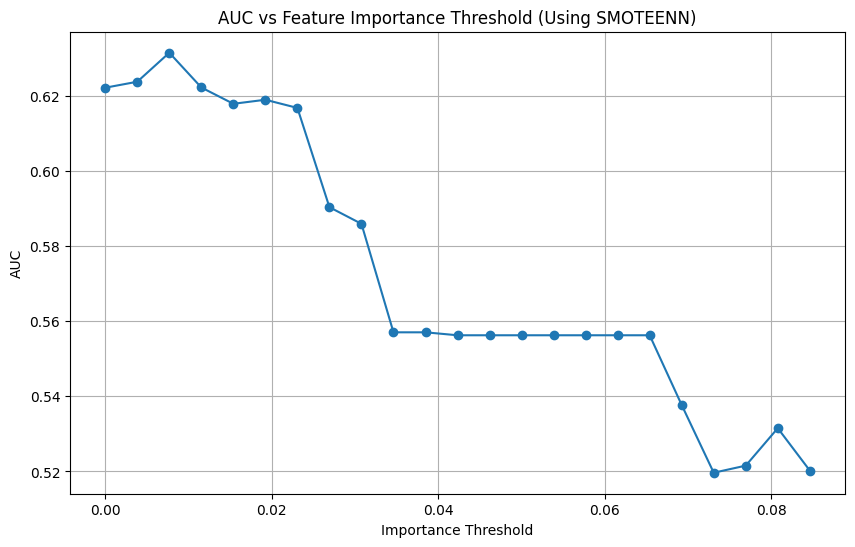

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = data_imputed.drop(['readmit_30d'], axis=1)
y = data_imputed['readmit_30d']

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initial Random Forest for feature importance
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

important_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Define thresholds and calculate AUC
thresholds = np.linspace(0, 0.15, 40)
auc_scores = []

for threshold in thresholds:
    selected_features = important_features[important_features['Importance'] > threshold]['Feature']
    if len(selected_features) == 0:
        continue

    selected_feature_indices = [X.columns.get_loc(feature) for feature in selected_features]
    X_train_selected = X_train[:, selected_feature_indices]
    X_test_selected = X_test[:, selected_feature_indices]

    # Apply SMOTEENN
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_selected, y_train)

    # Train and evaluate Random Forest
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X_train_resampled, y_train_resampled)
    y_pred_proba_rf = rf_model.predict_proba(X_test_selected)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba_rf)
    auc_scores.append((threshold, auc))

# Convert results to a DataFrame
auc_results = pd.DataFrame(auc_scores, columns=['Threshold', 'AUC'])

# Plot AUC vs Importance Threshold
plt.figure(figsize=(10, 6))
plt.plot(auc_results['Threshold'], auc_results['AUC'], marker='o')
plt.xlabel('Importance Threshold')
plt.ylabel('AUC')
plt.title('AUC vs Feature Importance Threshold (Using SMOTEENN)')
plt.grid()
plt.show()


In [17]:
# Find the threshold with the highest AUC
best_threshold = auc_results.loc[auc_results['AUC'].idxmax(), 'Threshold']
print(f"The best importance threshold is: {best_threshold}")

The best importance threshold is: 0.007692307692307692


In [18]:
important_features

,Feature,Importance
9,labtest_count,0.087693
3,los_hours,0.083101
12,max_a1c,0.081179
13,max_glucose,0.080434
7,age,0.074856
10,medication_count,0.072377
8,diagnoses_count,0.067072
11,procedure_count,0.039496
48,Complication,0.033324
5,discharge_location,0.031732


In [20]:
selected_features = important_features[important_features['Importance'] >  0.007692307692307692]['Feature']
selected_features

,Feature
9,labtest_count
3,los_hours
12,max_a1c
13,max_glucose
7,age
10,medication_count
8,diagnoses_count
11,procedure_count
48,Complication
5,discharge_location


In [21]:
selected_features_with_importance= important_features[important_features['Importance'] >  0.007692307692307692]
selected_features_with_importance

,Feature,Importance
9,labtest_count,0.087693
3,los_hours,0.083101
12,max_a1c,0.081179
13,max_glucose,0.080434
7,age,0.074856
10,medication_count,0.072377
8,diagnoses_count,0.067072
11,procedure_count,0.039496
48,Complication,0.033324
5,discharge_location,0.031732


In [22]:
len(selected_features)

24

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [24]:
X = data_imputed[selected_features]
y = data_imputed['readmit_30d']

In [25]:
X.head()

,labtest_count,los_hours,max_a1c,max_glucose,age,medication_count,diagnoses_count,procedure_count,Complication,discharge_location,...,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,insurance,diagnosis_5,ew_emer_stay,gender,observation_admit_stay,metformin
0,3,29,7.40,214.0,64,18,4,1,No,HOME,...,Neoplasms,Circulatory,Diabetes,Others,Private,Others,0.0,F,0.0,0
1,9,666,7.70,242.0,77,32,21,1,Unknown,ASSISTED LIVING,...,Others,Others,Others,Others,Private,Diabetes,0.0,M,0.0,1
2,266,287,6.62,182.0,84,43,13,2,No,SKILLED NURSING FACILITY,...,Circulatory,Genitourinary,Diabetes,Digestive,Medicare,Others,0.0,F,0.0,0
3,314,310,9.26,270.0,61,40,6,6,Unknown,HOME,...,Circulatory,Others,Circulatory,Diabetes,Private,Others,0.0,M,0.0,0
4,364,352,10.16,334.0,66,63,16,2,Unknown,REHAB,...,Circulatory,Respiratory,Others,Diabetes,Medicare,Others,0.0,M,0.0,0


In [26]:
# Encode categorical variables if any
categorical_columns = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

<ipython-input-26-48b6d69953aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
<ipython-input-26-48b6d69953aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
<ipython-input-26-48b6d69953aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [28]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Apply SMOTEENN to the training data
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_scaled, y_train)

print(f"Number of features: {X.shape[1]}")
print("Features used:")
print(X.columns.tolist())


Number of features: 24
Features used:
['labtest_count', 'los_hours', 'max_a1c', 'max_glucose', 'age', 'medication_count', 'diagnoses_count', 'procedure_count', 'Complication', 'discharge_location', 'admission_type', 'admission_location', 'total_num_of_stay', 'race', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_4', 'insurance', 'diagnosis_5', 'ew_emer_stay', 'gender', 'observation_admit_stay', 'metformin']


In [30]:
print(f"Shape of X_train_resampled: {X_train_resampled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

Shape of X_train_resampled: (17286, 24)
Shape of X_test_scaled: (6025, 24)


In [31]:
print("Original class distribution:")
print(y_train.value_counts(normalize=True))

print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original class distribution:
readmit_30d
0    0.849399
1    0.150601
Name: proportion, dtype: float64

Resampled class distribution:
readmit_30d
1    0.666262
0    0.333738
Name: proportion, dtype: float64


**X_train_resampled, y_train_resampled** <- smote varibles for training purpose

After the initial evaluation, we selected the top 5 models for further analysis. For these models, we prioritized both ROC-AUC and recall, as they reflect the model's overall performance and its ability to accurately identify true positive cases. This focus is particularly critical for predicting 30-day readmissions for T2DM, where intervention is significantly more cost-effective than addressing readmissions.

To achieve the best balance between ROC-AUC and recall, we manually tuned the hyperparameters of these models. Additionally, we employed random search as a conventional hyperparameter tuning method to explore potential improvements in performance.

### 2.Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [32]:
# Train
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = log_reg_model.predict(X_test_scaled)

# Evaluation
log_accuracy = accuracy_score(y_test, y_pred_class)
log_precision = precision_score(y_test, y_pred_class)
log_recall = recall_score(y_test, y_pred_class)
log_auc = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression Results:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"AUC: {log_auc:.4f}")

Logistic Regression Results:
Accuracy: 0.2998
Precision: 0.1631
Recall: 0.8842
AUC: 0.6163


In [40]:
# output the hyper parameter for LR

print("Logistic Regression Hyperparameters:")
print(log_reg_model.get_params())

Logistic Regression Hyperparameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


#### (1) Hyper parameter tuning for LR

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Define the parameter grid for LR
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    'l1_ratio': np.linspace(0, 1, 10),
    'class_weight': [None, 'balanced']
}

# Initialize the LR model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

# Define random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=log_reg_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 )

# Fit random search on the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)

# Evaluate the best model on the test set
best_log_reg_model = random_search.best_estimator_
y_pred_proba = best_log_reg_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = best_log_reg_model.predict(X_test_scaled)

log_accuracy = accuracy_score(y_test, y_pred_class)
log_precision = precision_score(y_test, y_pred_class)
log_recall = recall_score(y_test, y_pred_class)
log_auc = roc_auc_score(y_test, y_pred_proba)

print("Tuned Logistic Regression Results:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"AUC: {log_auc:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
39 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.1111111111111111, 'class_weight': None, 'C': 0.23357214690901212}
Best ROC-AUC Score: 0.7030930468789472
Tuned Logistic Regression Results:
Accuracy: 0.2981
Precision: 0.1627
Recall: 0.8831
AUC: 0.6163


Random search did not yield improved performance; therefore, we opted to retain the manually tuned hyperparameters for the Logistic Regression model.

Logistic regression has a best recall of 0.8842 and best AUC of 0.6163.

### 3.Random Forest

In [33]:
# Train
rf_model = RandomForestClassifier(random_state=42, n_estimators=100,  max_depth=10, min_samples_split=5)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_rf = rf_model.predict(X_test_scaled)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_class_rf)
rf_precision = precision_score(y_test, y_pred_class_rf)
rf_recall = recall_score(y_test, y_pred_class_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"AUC: {rf_auc:.4f}")


Random Forest Results:
Accuracy: 0.5466
Precision: 0.1977
Recall: 0.6582
AUC: 0.6258


#### (1) Hyper parameter tuning for RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize RF
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1)

# Perform RandomizedSearchCV on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_rf = random_search.best_estimator_

# Predict with the best estimator
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
y_pred_class_rf = best_rf.predict(X_test_scaled)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_class_rf)
rf_precision = precision_score(y_test, y_pred_class_rf)
rf_recall = recall_score(y_test, y_pred_class_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print("Best Hyperparameters:", random_search.best_params_)
print("Random Forest Results (with Hyperparameter Tuning):")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"AUC: {rf_auc:.4f}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Random Forest Results (with Hyperparameter Tuning):
Accuracy: 0.7321
Precision: 0.2279
Recall: 0.3264
AUC: 0.6299


Random forest has a best recall of 0.6582 and a best roc-auc of 0.6258.

### 4.LightGBM

In [ ]:
from lightgbm import LGBMClassifier

# Updated LightGBM with tuned hyperparameters
lgbm_model_tuned = LGBMClassifier(
    random_state=42,
    n_estimators=300,            # Increase number of trees for better learning
    learning_rate=0.05,          # Lower learning rate to focus on detail
    max_depth=7,                 # Restrict tree depth to avoid overfitting
    num_leaves=31,               # Optimal number of leaves based on max_depth
    min_child_samples=20,        # Minimum samples per leaf (reduce overfitting)
    colsample_bytree=0.8,        # Fraction of features used per tree
    subsample=0.8,               # Fraction of samples used for training each tree
    reg_alpha=1,                 # L1 regularization to reduce overfitting
    importance_type='gain'       # Use feature importance based on split gain
)

# Train the model
lgbm_model_tuned.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and classes
y_pred_proba_lgbm_tuned = lgbm_model_tuned.predict_proba(X_test_scaled)[:, 1]
y_pred_class_lgbm_tuned = (y_pred_proba_lgbm_tuned >= 0.4).astype(int)  # Adjust threshold for higher recall

# Evaluate the tuned model
lgbm_accuracy_tuned = accuracy_score(y_test, y_pred_class_lgbm_tuned)
lgbm_precision_tuned = precision_score(y_test, y_pred_class_lgbm_tuned)
lgbm_recall_tuned = recall_score(y_test, y_pred_class_lgbm_tuned)
lgbm_auc_tuned = roc_auc_score(y_test, y_pred_proba_lgbm_tuned)

print("Tuned LightGBM Results:")
print(f"Accuracy: {lgbm_accuracy_tuned:.4f}")
print(f"Precision: {lgbm_precision_tuned:.4f}")
print(f"Recall: {lgbm_recall_tuned:.4f}")
print(f"AUC: {lgbm_auc_tuned:.4f}")


[LightGBM] [Info] Number of positive: 11517, number of negative: 5769
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6116
[LightGBM] [Info] Number of data points in the train set: 17286, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666262 -> initscore=0.691325
[LightGBM] [Info] Start training from score 0.691325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

#### (1)Hyper parameter tuning for LightGBM

In [ ]:
# Hyper tuning for LightGBM

!pip install lightgbm scikit-optimize

import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Define the parameter search space
param_dist = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(3, 12),
    'min_child_samples': Integer(10, 50),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0),
}

# Initialize the LightGBM classifier
lgbm_model = lgb.LGBMClassifier(random_state=42, objective='binary')

# Initialize the Bayesian optimization search
opt = BayesSearchCV(
    lgbm_model,
    param_dist,
    n_iter=32,  # Number of iterations (adjust as needed)
    cv=3,      # Number of cross-validation folds (adjust as needed)
    n_jobs=-1, # Use all available cores
    scoring='roc_auc',  # Use AUC as the optimization metric
    verbose=1,
    random_state=42
)


# Perform the hyperparameter tuning
opt.fit(X_train_resampled, y_train_resampled)


# Print the best parameters and score
print("Best parameters:", opt.best_params_)
print("Best score:", opt.best_score_)


# Train the final model with the best parameters
best_lgbm_model = lgb.LGBMClassifier(**opt.best_params_, random_state=42, objective='binary')
best_lgbm_model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate the model
y_pred_proba_lgbm = best_lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_lgbm = best_lgbm_model.predict(X_test_scaled)

# Evaluation
lgbm_accuracy = accuracy_score(y_test, y_pred_class_lgbm)
lgbm_precision = precision_score(y_test, y_pred_class_lgbm)
lgbm_recall = recall_score(y_test, y_pred_class_lgbm)
lgbm_auc = roc_auc_score(y_test, y_pred_proba_lgbm)

print("LightGBM Results (Tuned):")
print(f"Accuracy: {lgbm_accuracy:.4f}")
print(f"Precision: {lgbm_precision:.4f}")
print(f"Recall: {lgbm_recall:.4f}")
print(f"AUC: {lgbm_auc:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candi

LightGBM has a best recall of 0.2889 and a best roc-auc of 0.6147.

### 5.Catboost

In [34]:
!pip install catboost

import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Initialize CatBoost classifier with tuned parameters
catboost_model_tuned = cb.CatBoostClassifier(
    random_state=42,
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=1,
    class_weights=[1, 4],
    subsample=0.8,
    verbose=0)

# Fit the tuned model
catboost_model_tuned.fit(X_train_resampled, y_train_resampled)

# Predict probabilities and classes
y_pred_proba_catboost_tuned = catboost_model_tuned.predict_proba(X_test_scaled)[:, 1]
y_pred_class_catboost_tuned = (y_pred_proba_catboost_tuned >= 0.4).astype(int)  # Adjust threshold for higher recall

# Evaluate the tuned model
catboost_accuracy_tuned = accuracy_score(y_test, y_pred_class_catboost_tuned)
catboost_precision_tuned = precision_score(y_test, y_pred_class_catboost_tuned)
catboost_recall_tuned = recall_score(y_test, y_pred_class_catboost_tuned)
catboost_auc_tuned = roc_auc_score(y_test, y_pred_proba_catboost_tuned)

print("Tuned CatBoost Results:")
print(f"Accuracy: {catboost_accuracy_tuned:.4f}")
print(f"Precision: {catboost_precision_tuned:.4f}")
print(f"Recall: {catboost_recall_tuned:.4f}")
print(f"AUC: {catboost_auc_tuned:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
Tuned CatBoost Results:
Accuracy: 0.3954
Precision: 0.1769
Recall: 0.8258
AUC: 0.6292


#### (1) Hyper parameter tuning for Catboost

In [ ]:
!pip install catboost scikit-optimize

import catboost as cb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100, 200],
    'random_strength': [1, 5, 10],
    'bagging_temperature': [0, 0.5, 1],
    'od_type': ['IncToDec', 'IncToDec', 'IncToDec'],
    'od_wait': [10, 20, 30]
}

# Initialize CatBoost
catboost_model = cb.CatBoostClassifier(random_seed=42, verbose=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Perform RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator
best_catboost_model = random_search.best_estimator_

# Predict with the best estimator
y_pred_proba_catboost = best_catboost_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
catboost_auc = roc_auc_score(y_test, y_pred_proba_catboost)

print("Best Hyperparameters:", random_search.best_params_)
print(f"CatBoost AUC (Tuned): {catboost_auc:.4f}")

Best Hyperparameters: {'random_strength': 10, 'od_wait': 30, 'od_type': 'IncToDec', 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 8, 'border_count': 200, 'bagging_temperature': 1}
CatBoost AUC (Tuned): 0.6204


CatBoost has a best recall of 0.8258 and a best roc-auc of 0.6292.

### 6.XGBoost

In [34]:
# Train
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',learning_rate=0.01)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
xgb_accuracy = accuracy_score(y_test, y_pred_class_xgb)
xgb_precision = precision_score(y_test, y_pred_class_xgb)
xgb_recall = recall_score(y_test, y_pred_class_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC: {xgb_auc:.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.4120
Precision: 0.1781
Recall: 0.8037
AUC: 0.6177


#### (1) Hyper parameter tuning for XGBoost

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np

# Define the parameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 300, 500, 700],          # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 5, 7, 10],                   # Maximum depth of a tree
    'min_child_weight': [1, 3, 5, 7],             # Minimum sum of instance weights in a child node
    'subsample': [0.6, 0.8, 1.0],                 # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],          # Fraction of features used per tree
    'gamma': [0, 0.1, 0.3, 0.5],                  # Minimum loss reduction for a split
    'reg_alpha': [0, 0.1, 1, 10],                 # L1 regularization term
    'reg_lambda': [1, 10, 100],                   # L2 regularization term
    'scale_pos_weight': [1, 3, 5, 10]             # Handling class imbalance
}

# Define random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=3,               # 3-fold cross-validation
    verbose=2,          # Display progress
    random_state=42,    # For reproducibility
    n_jobs=-1           # Use all available processors
)

# Fit random search on the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best ROC-AUC Score:", random_search.best_score_)

# Evaluate the best model on the test set
best_xgb_model = random_search.best_estimator_
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_class_xgb = best_xgb_model.predict(X_test_scaled)

xgb_accuracy = accuracy_score(y_test, y_pred_class_xgb)
xgb_precision = precision_score(y_test, y_pred_class_xgb)
xgb_recall = recall_score(y_test, y_pred_class_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print("Tuned XGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC: {xgb_auc:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 10, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best ROC-AUC Score: 0.9660064339536332
Tuned XGBoost Results:
Accuracy: 0.4876
Precision: 0.1895
Recall: 0.7332
AUC: 0.6225


XGBoost has a best recall of 0.8037 and a best roc-auc of 0.6177.

Overall, LR, Catboost and XGBoost are our best 3 models.

## D. Checking overfitting for best 3 models

### 1.Learning curve of Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

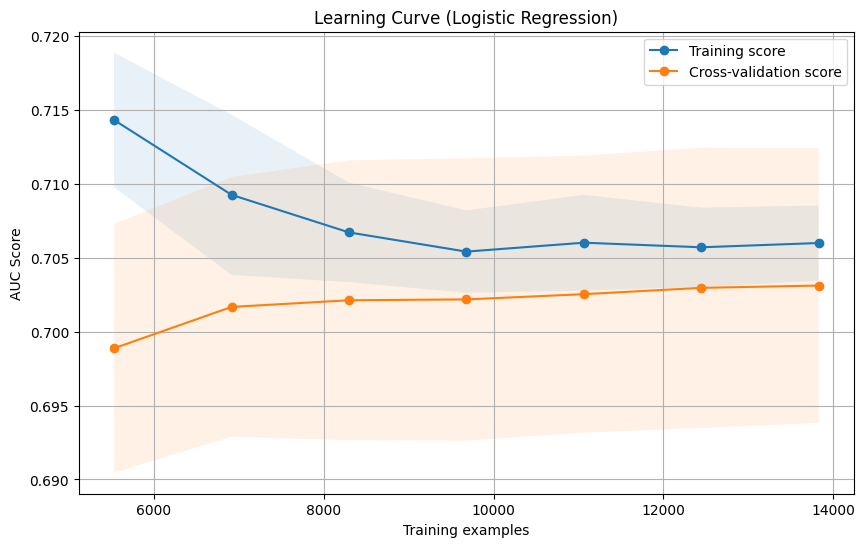

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# learning curve of lr
train_sizes, train_scores, test_scores = learning_curve(
    log_reg_model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("AUC Score")
plt.title("Learning Curve (Logistic Regression)")
plt.legend(loc="best")
plt.grid()
plt.show()

### 2.Learning curve of Catboost

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2410, in _fi

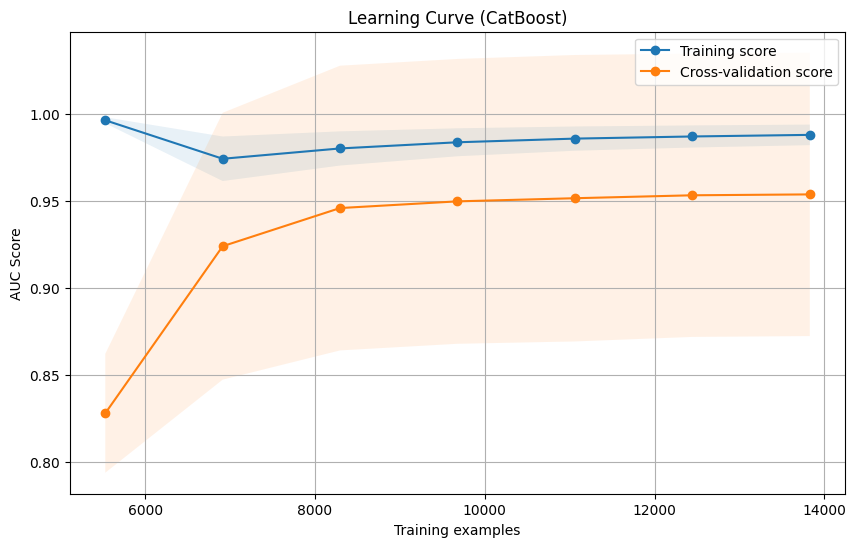

In [ ]:
# draw a learning curve of catboost

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    catboost_model_tuned, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("AUC Score")
plt.title("Learning Curve (CatBoost)")
plt.legend(loc="best")
plt.grid()
plt.show()

### 3.Learning curve of XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib

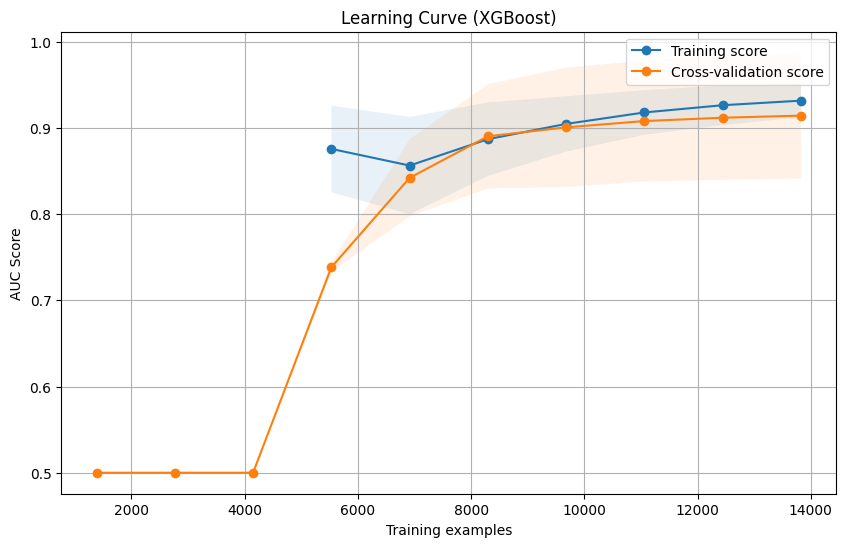

In [35]:
# draw a learning curve of xgb_model

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel("Training examples")
plt.ylabel("AUC Score")
plt.title("Learning Curve (XGBoost)")
plt.legend(loc="best")
plt.grid()
plt.show()

There are no overfitting sign for all 3 top models.